# Skeleton Threat Detection

In [1]:
import time
import numpy as np
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

# Part 1: Load Data

In [2]:
x = np.empty((1,9,2))
rele_dexes = [1,2,3,4,5,6,7,9,12]
right_elbow = 3
right_wrist = 4
folders = ["High_ordered/keypoints/", "Medium_ordered/keypoints/", "Low_ordered/keypoints/"]
threats = [0,1,2]
y = []
last_count = 0
for folder in range(len(folders)):
    for f in listdir(folders[folder]):
        skeletons = np.load(folders[folder]+f)
        if skeletons.size != 1:
            for skele in skeletons:
                if skele[rele_dexes].all() > .0001:
                    skele[:,0:2] -= skele[right_elbow,0:2]
                    forearm_len = np.sqrt(skele[right_wrist][0]**2+skele[right_wrist][1]**2)
                    skele[:,0:2] /= forearm_len
                    x = np.vstack((x,np.expand_dims(skele[rele_dexes,0:2],axis=0)))
    y = np.concatenate((y,[threats[folder]]*(x.shape[0]-last_count)))
    last_count = x.shape[0]
                    
x = x.reshape([x.shape[0],x.shape[1]*x.shape[2]])

        
print(x.shape)
print(y.shape)
print(x[-1])

(1549, 18)
(1549,)
[-1.14879715 -1.0680207  -0.50251734 -1.15777564  0.          0.
  0.43987265  0.8980602  -1.73252392 -0.94244558 -1.82236588  0.10790823
 -1.80436289  0.52977294 -0.84384251  0.57481354 -1.58882546  0.55679184]


In [3]:
train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=.15)

oh_train_y = np.array(train_y,dtype=np.int64)
num_labels = len(np.unique(oh_train_y))
oh_train_y = np.eye(num_labels)[oh_train_y]

oh_test_y = np.array(test_y,dtype=np.int64)
num_labels = len(np.unique(oh_test_y))
oh_test_y = np.eye(num_labels)[oh_test_y]

print(train_x.shape)
print(test_x.shape)
print(len(oh_train_y))
print(len(oh_test_y))

# columns: x, y, confidence
# https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md

(1316, 18)
(233, 18)
1316
233


# Create and Train Model

In [4]:
from feedforward_model import *

In [5]:
model = feedforward(x.shape[1],len(threats),hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [6]:
model.train(train_x,oh_train_y,test_x,oh_test_y,epochs=30,batch_size=64)

number of batches for training: 20
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.63090128755365%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.63519313304721%
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 44.63519313304721. Model named basic_model.


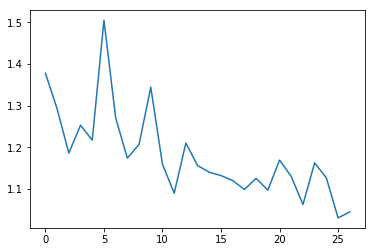

In [7]:
model.plot()

In [8]:
labels = np.array(['high','med','low'])
test = np.reshape(test_x[0],(1,len(test_x[0])))
prediction = model.predict(test)
print("Predicted label is ", labels[prediction[0][0]])
tested_y = np.ndarray.astype(oh_test_y[0],bool)
print("Actual label is ",labels[tested_y][0])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model/basic_model
Predicted label is  high
Actual label is  high


In [9]:
predictions = model.predict(test_x)
conf_mat = confusion_matrix(test_y,predictions[0])
print(conf_mat)
prob = np.empty(conf_mat.shape,dtype=np.float32)
for i in range(conf_mat.shape[0]):
    prob[i] = np.divide(conf_mat[i],sum(conf_mat[i]))
    
print(prob*100)

INFO:tensorflow:Restoring parameters from model/basic_model
[[104   0   0]
 [ 35   0   0]
 [ 94   0   0]]
[[100.   0.   0.]
 [100.   0.   0.]
 [100.   0.   0.]]


In [14]:
session = tf.Session()
with session as sess:
    new_saver = tf.train.import_meta_graph('model/basic_model.meta')
    new_saver.restore(sess, 'model/basic_model')
    graph = tf.get_default_graph()
    input_ph = graph.get_tensor_by_name("input_ph:0")
    pred = graph.get_tensor_by_name("pred:0")
    # if pre_trained_model != None:
    #     try:
    #         print("Loading model from: {}".format(pre_trained_model))
    #         self.saver.restore(sess,'model/{}'.format(pre_trained_model))
    #     except Exception:
    #         raise ValueError("Failed Loading Model")
    # else:
    #     chkp.print_tensors_in_checkpoint_file(tf.train.latest_checkpoint('model/'), tensor_name='', all_tensors=True)
    #     self.saver.restore(sess,tf.train.latest_checkpoint('model/'))
    pred = sess.run([pred],feed_dict={input_ph: test})
    print(pred)

INFO:tensorflow:Restoring parameters from model/basic_model
[array([0])]


In [ ]:
from detection_code import *

In [ ]:
print(prediction(test,model_name="basic_model"))